In [0]:
%pip install pandas_datareader
%pip install yfinance
%pip install investpy
%pip install PyPortfolioOpt

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-2b241db6-11dd-45d0-a89b-cd5c5ea93d8b
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: setuptools
    Found existing installation: setuptools 61.2.0
    Not uninstalling setuptools at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-2b241db6-11dd-45d0-a89b-cd5c5ea93d8b
    Can't uninstall 'setuptools'. No files were found to uninstall.
Python interpreter will be restarted.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from matplotlib.ticker import FuncFormatter
from pypfopt import objective_functions, base_optimizer
from scipy.stats import norm
import math
yfin.pdr_override()

# Stock Portfolio MC simulations: Functions

In [0]:

def stock_gen(stock_list):
  '''
  stock_list-list input
  Generate list of stock tickers to extract their relevant historic closing values
  list output
  '''
  return [stock for stock in stockList]




def get_stock_data(stock_list, days_diff_from_today):
  '''
  stock_list-list, days_diff_from_today-integer inputs
  Generate the meanreturns for the stocks in question, the relevant covariance matrix and the wights for each stock
  meanreturns-numpyarray, covmatrix-dataframe, weights-numpyarray outputs
  '''
  end = str(dt.date.today())
  start = str(dt.date.today() - dt.timedelta(days=days_diff_from_today))
  stocks = stock_gen(stock_list)
  stockdata = pdr.get_data_yahoo(stocks[0::], start, end)
  stockdata = stockdata['Close']
  returns = stockdata.pct_change()
  meanreturns = returns.mean()
  covmatrix = returns.cov()
  weights = np.random.random(len(meanreturns))
  weights /= np.sum(weights)
  return meanreturns, covmatrix, weights




def mc_simulation_stocks(initial_portfolio_value, simulations, days, weights, meanreturns, covmatrix):
  '''
  initial_portfolio_value-integer, simulations-integer, days-integer, weights-numpyarray, meanreturns-numpyarray, covmatrix-dataframe inputs
  Perform MC simulations for a given initial portfolio value for a specific timeframe in days (trading days in a year normally)
  pandasSeriesobject output
  '''
  meanm = np.full(shape=(T, len(weights)), fill_value=meanreturns)
  meanm = meanm.T

  portfolio_simulations = np.full(shape=(T, simulations), fill_value=0.0)

  for i in range(0, simulations):
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covmatrix) 
    dailyreturns = meanm + np.inner(L, Z) 
    portfolio_simulations[:,i] = np.cumprod(np.inner(weights, dailyreturns.T)+1)*initial_portfolio_value

  plt.figure(figsize=(20, 10), facecolor = 'white')
  plt.plot(portfolio_simulations)
  plt.ylabel('Portfolio Value ($)')
  plt.xlabel('Days')
  plt.title(f'Monte carlo simulation of a stock portfolio: {simulations} simulations with an initial portfolio value of {initial_portfolio_value} $')
  plt.show()

  return pd.Series(portfolio_simulations[-1,:])




def mcvar(returns, alpha):
  """
  returns-pandasSeries, alpha-integer inputs
  Calculate the VAR of the given simulated portfolio. This is done to a given confidence level alplha
  float output
  """
  if isinstance(returns, pd.Series):
    return np.percentile(returns, alpha)
  else:
    raise TypeError("Expected a pandas data series.")




def mccvar(returns, alpha):
  """ 
  returns-pandasSeries, alpha-integer inputs
  Calculate the cVAR (expected shortfall) of the given simulated portfolio. This is done to a given confidence level alplha
  float output
  """
  if isinstance(returns, pd.Series):
    belowVaR = returns <= mcvar(returns, alpha=alpha)
    return returns[belowVaR].mean()
  else:
    raise TypeError("Expected a pandas data series.")




def max_loss(portfolio_results, alpha):
  '''
  portfolio_results-pandasSeriesobject, alpha-integer inputs
  Estimate the expected shortfall of the given simulated portfolio
  None output
  '''
  var = initial_portfolio_value - mcvar(portfolio_results, alpha)
  cvar = initial_portfolio_value - mccvar(portfolio_results, alpha)

  print('var ${:,.2f}'.format(var,2))
  print('cvar ${:,.2f}'.format(cvar,2))

# Stock Portfolio MC simulations

In [0]:
stock_list = ['BNS.TO', 'GOOGL', 'XOM', 'NIO', 'KO', 'PEP','ARCC','IBM','AGNC','LCID']
days_diff_from_today = 10000

meanreturns, covmatrix, weights = get_stock_data(stock_list, days_diff_from_today)

[*********************100%***********************]  10 of 10 completed


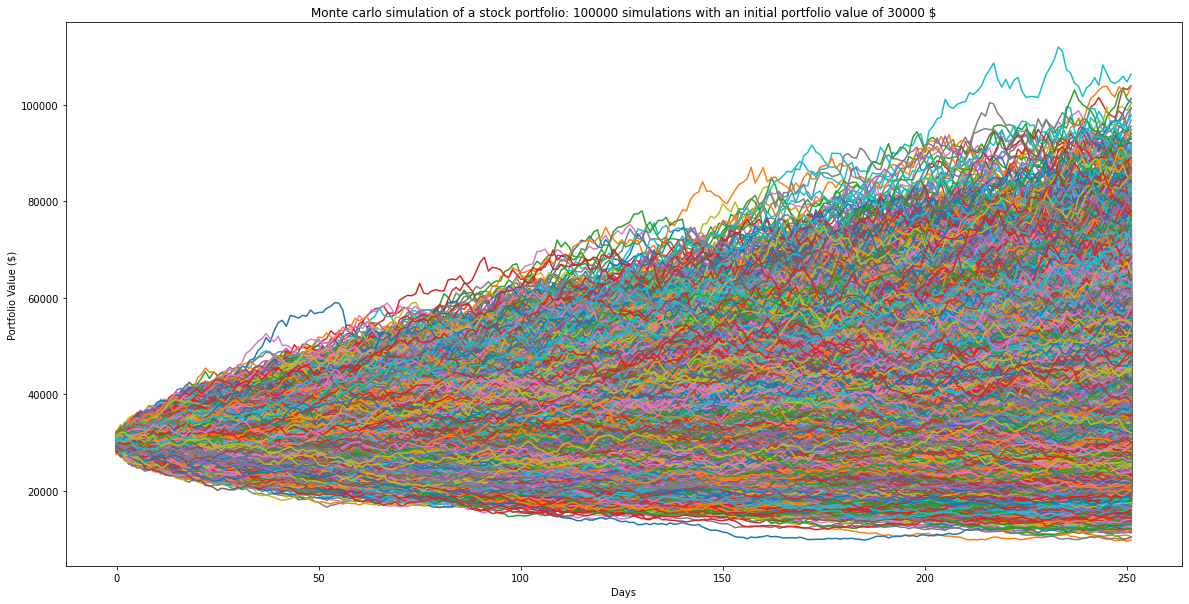

var $7,822.52
cvar $10,133.51


In [0]:
initial_portfolio_value = 30000
simulations = 100000
days = 252
alpha = 5

portfolio_results = mc_simulation_stocks(initial_portfolio_value, simulations, days, weights, meanreturns, covmatrix)
max_loss(portfolio_results, alpha)

# Stock Portfolio Optimisation MC simulations: Functions

In [0]:
def extract_data(tickers, length, days_diff_from_today):
  '''
  tickers-list, length-integer, days_diff_from_today-integer inputs
  Extract stock historic data for given/selected stocks
  df_stocks-dataframe output
  '''
  end = str(dt.date.today())
  start = str(dt.date.today() - dt.timedelta(days=days_diff_from_today))
  price_data = []
  for i in range(length):
    stocks = pdr.get_data_yahoo(tickers[i], start=start, end = end)
    price_data.append(stocks[['Adj Close']])
  df_stocks = pd.concat(price_data, axis=1)
  df_stocks.columns=tickers
  return df_stocks




def returns_sharpe(tickers, data, length):
  '''
  tickers-list, data-dataframe, length-integer inputs
  Calculate and plot the % change for each stock after assigning aweighting to it using the sharpe ratio
  ticker_final-dataframe, sh_wt-numpyarray outputs
  '''
  mu = expected_returns.mean_historical_return(data)
  Sigma = risk_models.sample_cov(data)
  ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) 
  sharpe_pfolio=ef.max_sharpe() 
  sharpe_pwt=ef.clean_weights()
  print(sharpe_pwt)
  ticker_rx2 = []
  sh_wt = list(sharpe_pwt.values())
  sh_wt=np.array(sh_wt)
  for a in range(length):
    ticker_rx = data[[tickers[a]]].pct_change()
    ticker_rx = (ticker_rx+1).cumprod()
    ticker_rx2.append(ticker_rx[[tickers[a]]])
  ticker_final = pd.concat(ticker_rx2,axis=1)
  ticker_final
  plt.figure(figsize=(20, 10), facecolor = 'white')
  for i, col in enumerate(ticker_final.columns):
    ticker_final[col].plot()
  plt.title('Cumulative Returns')
  plt.xticks(rotation=80)
  plt.legend(ticker_final.columns)
  plt.show()
  return ticker_final, sh_wt




def latest_return(length, ticker_final, sh_wt):
  '''
  length-integer, ticker_final-dataframe, sh_wt-numpyarray inputs
  Calculate the estimated weighted average portfolio return for the period of historic data selected
  varsigma-float, ex_rtn-float outputs
  '''
  pret = []
  pre1 = []
  price =[]
  for x in range(length):
    pret.append(ticker_final.iloc[[-1],[x]])
    price.append((df_stocks.iloc[[-1],[x]]))
  pre1 = pd.concat(pret,axis=1)
  pre1 = np.array(pre1)
  price = pd.concat(price,axis=1)
  varsigma = pre1.std()
  ex_rtn=pre1.dot(sh_wt)
  print(f'The weighted expected portfolio return for selected time period is {str(ex_rtn)}')
  price=price.dot(sh_wt) 
  print(ex_rtn, varsigma,price)
  return varsigma, ex_rtn




def daily_return(varsigma, ex_rtn, portfolio_value, days):
  '''
  varsigma-float, ex_rtn-float, portfolio_value-integer, days-integer
  Simulate using MC for a given number of trading days the portfolio value and the minimum daily losses
  None output
  '''
  lt_price=[]
  final_res=[]
  for i in range(10000):
    daily_return=                     (np.random.normal(ex_rtn/days,varsigma/math.sqrt(days),days))
    plt.plot(daily_return)
  plt.axhline(np.percentile(daily_return,5), color='r', linestyle='dashed', linewidth=1)
  plt.axhline(np.percentile(daily_return,95), color='g', linestyle='dashed', linewidth=1)
  plt.axhline(np.mean(daily_return), color='b', linestyle='solid', linewidth=1)
  plt.show()

  plt.hist(daily_return,bins=15)
  plt.axvline(np.percentile(daily_return,5), color='r', linestyle='dashed', linewidth=2)
  plt.axvline(np.percentile(daily_return,95), color='r', linestyle='dashed', linewidth=2)
  plt.show()

  print(np.percentile(daily_return,5),np.percentile(daily_return,95)) 
  print('$Amount required to cover minimum losses for one day is ' + str(portfolio_value* - np.percentile(daily_return,5)))


# Stock Portfolio Optimisation MC Simulations

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
OrderedDict([('GOOGL', 0.46344), ('AAPL', 0.22177), ('NFLX', 0.18159), ('AMZN', 0.13321)])


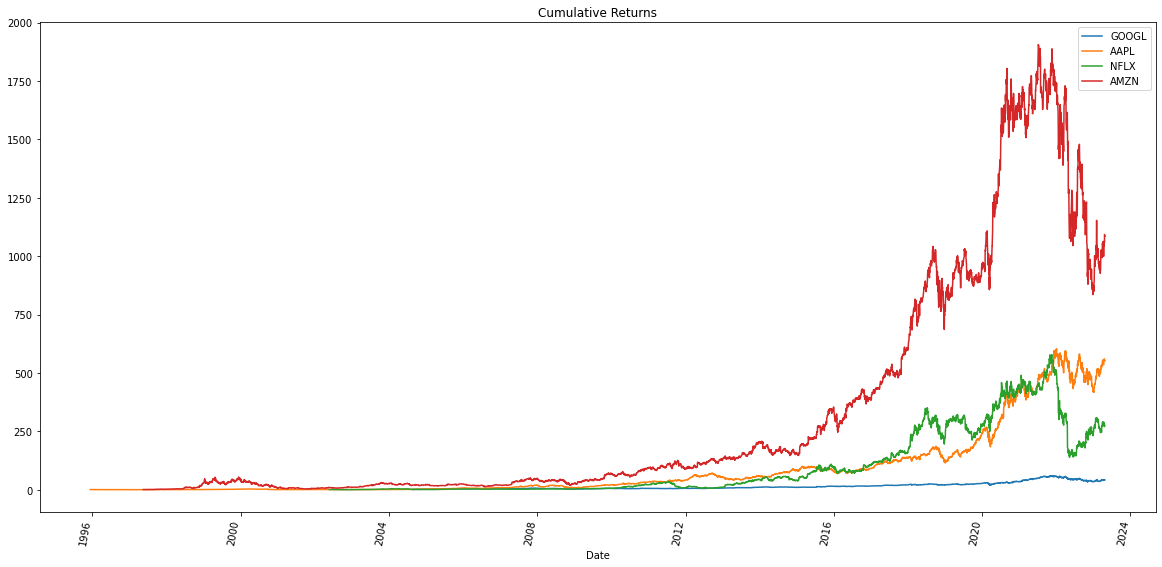

The weighted expected portfolio return for selected time period is [336.52314618]
[336.52314618] 388.6872342692247 Date
2020-06-19    152.282507
dtype: float64


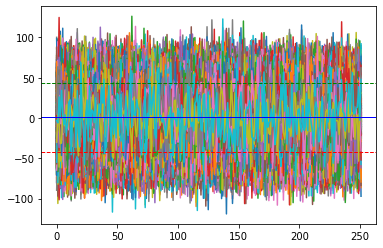

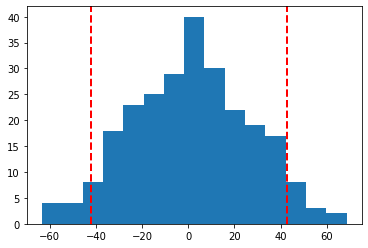

-42.34077135988869 42.891391643413584
$Amount required to cover minimum losses for one day is 1270223.1407966607


In [0]:
tickers = ['GOOGL','AAPL','NFLX','AMZN']
length = len(tickers)
days_diff_from_today =10000
days = 252
portfolio_value = 30000

data = extract_data(tickers, length, days_diff_from_today)
ticker_final, sh_wt = returns_sharpe(tickers, data, length)
varsigma, ex_rtn = latest_return(length, ticker_final, sh_wt)
daily_return(varsigma, ex_rtn, portfolio_value, days)
